# LSTM Baseline Model Testing

## 0 Imports & Constants

In [34]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utilities import load_complete_time_series, split_data_into_sequences, reconstruct_sequential_data, Scaler, train_test_split, extract_features_and_targets
from LSTM import LSTM, train_model
from TimeSeriesDataset import TimeSeriesDataset
from mean_regressor import MeanRegressor

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [38]:
SEQ_LEN = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [39]:
FEATURES = ['Close', 'Volume']

## 2 Data

### Data Loading

In [40]:
# Load data from csv
# -> convert Date column to datetime
data = load_complete_time_series(f'{REAL_DATA_FOLDER}/AAPL_complete_no_date.csv')
data = data[FEATURES] # remember to put the target column first
data[SEQ_LEN-1:SEQ_LEN+10]

,Close,Volume
14,0.150670,35728000
15,0.143973,45158400
16,0.137835,55686400
17,0.135045,39827200
18,0.142299,21504000
19,0.141183,23699200
20,0.136161,23049600
21,0.136719,14291200
22,0.139509,14067200
23,0.138393,13395200


In [41]:
data_numpy = data.to_numpy()

### Preprocessing for Dummy model

In [42]:
dummy_train, dummy_test = train_test_split(data_numpy, split_ratio=0.97)
dummy_train_sequences = split_data_into_sequences(dummy_train, SEQ_LEN)
dummy_test_sequences = split_data_into_sequences(dummy_test, SEQ_LEN)
_, _, dummy_X_test, dummy_y_test = extract_features_and_targets(dummy_train_sequences, dummy_test_sequences)

Shape of the data after splitting into sequences: (10634, 15, 2)
Shape of the data after splitting into sequences: (316, 15, 2)
Extracted features and target from training and test data.
Shape of X_train: torch.Size([10634, 14, 2])
Shape of y_train: torch.Size([10634, 1])
Shape of X_test: torch.Size([316, 14, 2])
Shape of y_test: torch.Size([316, 1])


### Data Preprocessing

In [43]:
data_train, data_test = train_test_split(data_numpy, split_ratio=0.97)

In [44]:
data_train_seq = split_data_into_sequences(data_train, SEQ_LEN)
data_test_seq = split_data_into_sequences(data_test, SEQ_LEN)

Shape of the data after splitting into sequences: (10634, 15, 2)
Shape of the data after splitting into sequences: (316, 15, 2)


In [45]:
scaler = Scaler(data_train_seq)

In [46]:
data_train_seq_scaled = scaler.scale_data(data_train_seq)
data_test_seq_scaled = scaler.scale_data(data_test_seq)

In [47]:
data_test_seq_scaled[-1]

array([[1.06105708, 0.0131052 ],
       [1.13816155, 0.02322577],
       [1.17069609, 0.02669683],
       [1.17712603, 0.01318613],
       [1.16750858, 0.00944841],
       [1.19048051, 0.01262905],
       [1.17740075, 0.01077165],
       [1.15206564, 0.01161098],
       [1.14003015, 0.03320309],
       [1.14360231, 0.01087724],
       [1.14871334, 0.00764169],
       [1.17168527, 0.00892164],
       [1.17635664, 0.00670643],
       [1.15723159, 0.01112189],
       [1.19092018, 0.00812745]])

In [48]:
X_train, y_train, X_test, y_test = extract_features_and_targets(data_train_seq_scaled, data_test_seq_scaled)

Extracted features and target from training and test data.
Shape of X_train: torch.Size([10634, 14, 2])
Shape of y_train: torch.Size([10634, 1])
Shape of X_test: torch.Size([316, 14, 2])
Shape of y_test: torch.Size([316, 1])


In [15]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 14, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [18]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=X_train.shape[2], # number of features
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()

In [20]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 0.006950397358741612
**************************************************
Epoch: 2
Validation Loss: 0.005420546198729425
**************************************************
Epoch: 3
Validation Loss: 0.0035927086719311774
**************************************************
Epoch: 4
Validation Loss: 0.0028669462830293924
**************************************************
Epoch: 5
Validation Loss: 0.0024133476603310556
**************************************************
Epoch: 6
Validation Loss: 0.0023666535620577634
**************************************************
Epoch: 7
Validation Loss: 0.0008763455582084135
**************************************************
Epoch: 8
Validation Loss: 0.0023705464787781238
INFO: Validation loss did not improve in epoch 8
**************************************************
Epoch: 9
Validation Loss: 0.0006873868813272565
**************************************************
Epoch: 10
Validation Loss: 0.0005091958213597536
*************

## 4 Plot Predictions

### Inverse Transform

In [21]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [22]:
test_pred = scaler.inverse_scale_data(test_pred, feature_type='price')
train_pred = scaler.inverse_scale_data(train_pred, feature_type='price')
y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

In [23]:
loss = criterion_absolute(torch.tensor(test_pred), torch.tensor(y_test)).item()
loss

1.927989429587926

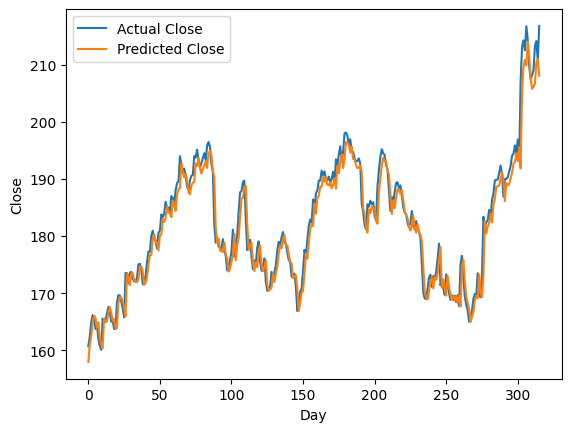

In [24]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


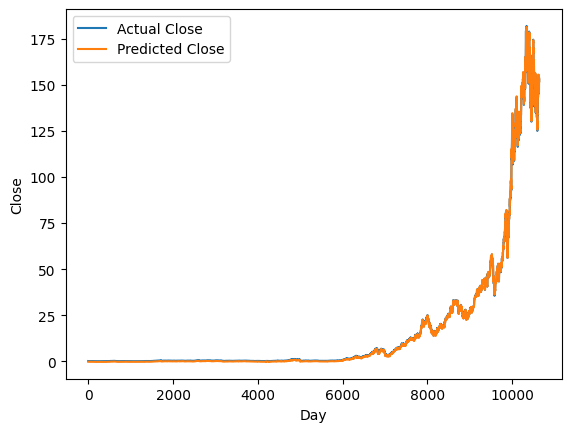

In [25]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


### Dummy Testing

In [26]:
dummy_model = MeanRegressor()
dummy_pred = dummy_model.make_predictions(dummy_X_test)

In [27]:
dummy_pred.shape

(316,)

In [28]:
loss = criterion_absolute(torch.tensor(dummy_pred), dummy_y_test).item()
loss

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([316, 1])) that is different to the input size (torch.Size([316])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


13.001367646384134

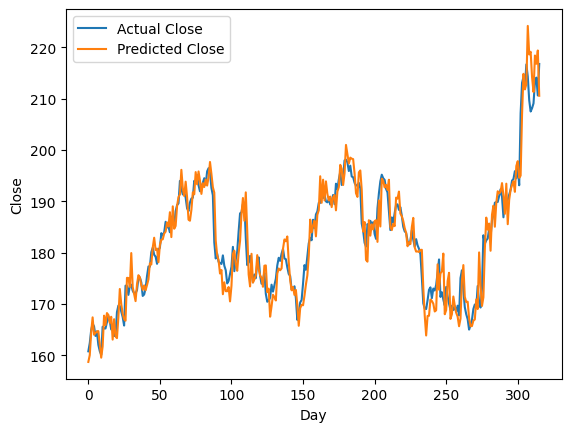

In [29]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(dummy_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()